In [2]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from scipy.integrate import cumulative_trapezoid
from astropy.coordinates import SkyCoord

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:193: GalaFutureWarning: In a future version of Gala, the current MilkyWayPotential and MilkyWayPotential2022 classes will be combined into a single class, MilkyWayPotential, with an optional 'version' argument to select between the models. To use the old (version 1) MilkyWayPotential, specify version="v1" when creating an instance. To use the newer (version 2 = current MilkyWayPotential2022), specify version="v2".
  warnings.warn(
/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(


In [3]:
%config InlineBackend.figure_format = 'retina'


pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.7*fs,
          'legend.title_fontsize': 0.8*fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [4]:
pop_files = ["binaries", "binaries-kickflag-5-ecsn-0", "binaries-kickflag-1-ecsn-2.25",
             "binaries-kickflag-1-ecsn-0"]
pops = [cogsworth.pop.load(f"/mnt/ceph/users/twagg/underworld/{f}", parts=[]) for f in pop_files]

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(
/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(
/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential20

In [5]:
labels = ["Disberg", "Disberg, No ECSN", "Hobbs", "Hobbs, No ECSN"]
for pop, f in zip(pops, labels):
    pop.label = f

for i, pop in enumerate(pops):
    pop.colour = mpl.colormaps['tab10'].colors[i]
    pop.bpp["row_num"] = np.arange(len(pop.bpp))

In [6]:
kinematics = {}

for pop in pops:
    kinematics[pop.label] = {}
    primary_pos = pop.final_pos[:len(pop)]
    secondary_pos = pop.final_pos[:len(pop)].copy()
    secondary_pos[pop.disrupted] = pop.final_pos[len(pop):]

    ns_pos = np.concatenate((primary_pos[pop.final_bpp["kstar_1"] == 13],
                            secondary_pos[pop.final_bpp["kstar_2"] == 13]))
    bh_pos = np.concatenate((primary_pos[pop.final_bpp["kstar_1"] == 14],
                            secondary_pos[pop.final_bpp["kstar_2"] == 14]))
    co_pos = np.concatenate((ns_pos, bh_pos))

    kinematics[pop.label]["pos"] = {
        "NS": ns_pos,
        "BH": bh_pos,
        "CO": co_pos,
    }

    primary_vel = pop.final_vel[:len(pop)]
    secondary_vel = pop.final_vel[:len(pop)].copy()
    secondary_vel[pop.disrupted] = pop.final_vel[len(pop):]

    ns_vel = np.concatenate((primary_vel[pop.final_bpp["kstar_1"] == 13],
                             secondary_vel[pop.final_bpp["kstar_2"] == 13]))
    bh_vel = np.concatenate((primary_vel[pop.final_bpp["kstar_1"] == 14],
                             secondary_vel[pop.final_bpp["kstar_2"] == 14]))
    co_vel = np.concatenate((ns_vel, bh_vel))

    kinematics[pop.label]["vel"] = {
        "NS": ns_vel,
        "BH": bh_vel,
        "CO": co_vel,
    }

Inner 10 kpc
  Disberg fraction within 0.5 kpc 0.47
  Hobbs fraction within 0.5 kpc 0.44
Full population
  Disberg fraction within 0.5 kpc 0.37
  Hobbs fraction within 0.5 kpc 0.29


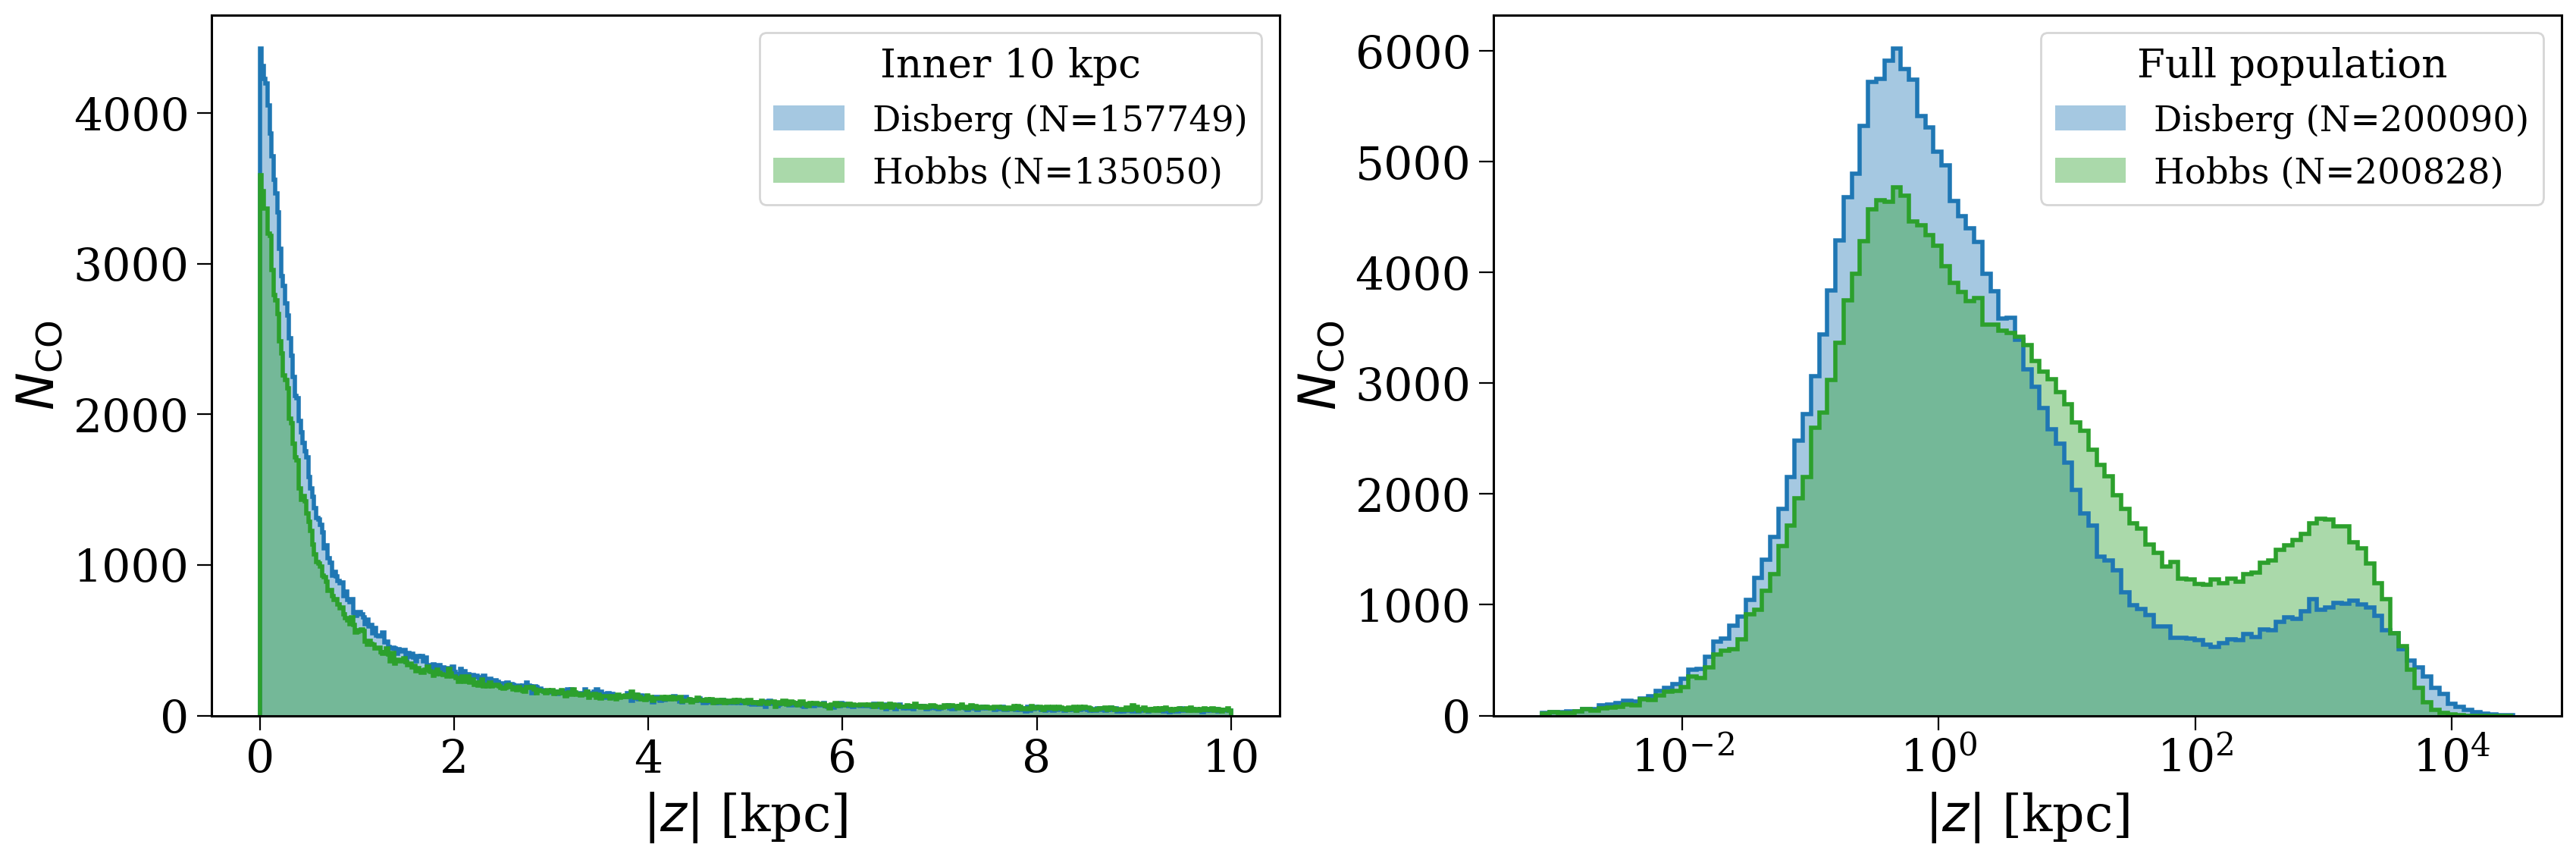

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

scales = ['linear', 'log']
bin_list = [np.linspace(0, 10, 501), np.geomspace(8e-4, 3e4, 120)]
labels = ['Inner 10 kpc', 'Full population']

for ax, scale, bins, label in zip(axes, scales, bin_list, labels):
    print(label)
    for pop in pops:
        if "ECSN" in pop.label:
            continue
        co_pos = kinematics[pop.label]["pos"]["CO"]

        mask = np.abs(co_pos[:, 2].to(u.kpc).value) < bins[-1]
        print(f"  {pop.label} fraction within 0.5 kpc {(abs(co_pos[:, 2].to(u.kpc).value) < 0.5).sum() / mask.sum():1.2f}")

        ax.hist(np.abs(co_pos[:, 2].to(u.kpc).value), bins=bins, histtype='step', lw=2, color=pop.colour)
        ax.hist(np.abs(co_pos[:, 2].to(u.kpc).value), bins=bins, alpha=0.4, color=pop.colour,
                label=f'{pop.label} (N={len(co_pos[mask])})')

    ax.set(
        xscale=scale,
        xlabel=r'$|z|$ [kpc]',
        ylabel=r'$N_{\rm CO}$',
    )
    ax.legend(title=label)
plt.show()

Inner 10 kpc
  Hobbs fraction within 0.5 kpc 0.44
  Hobbs, No ECSN fraction within 0.5 kpc 0.43
Full population
  Hobbs fraction within 0.5 kpc 0.29
  Hobbs, No ECSN fraction within 0.5 kpc 0.29


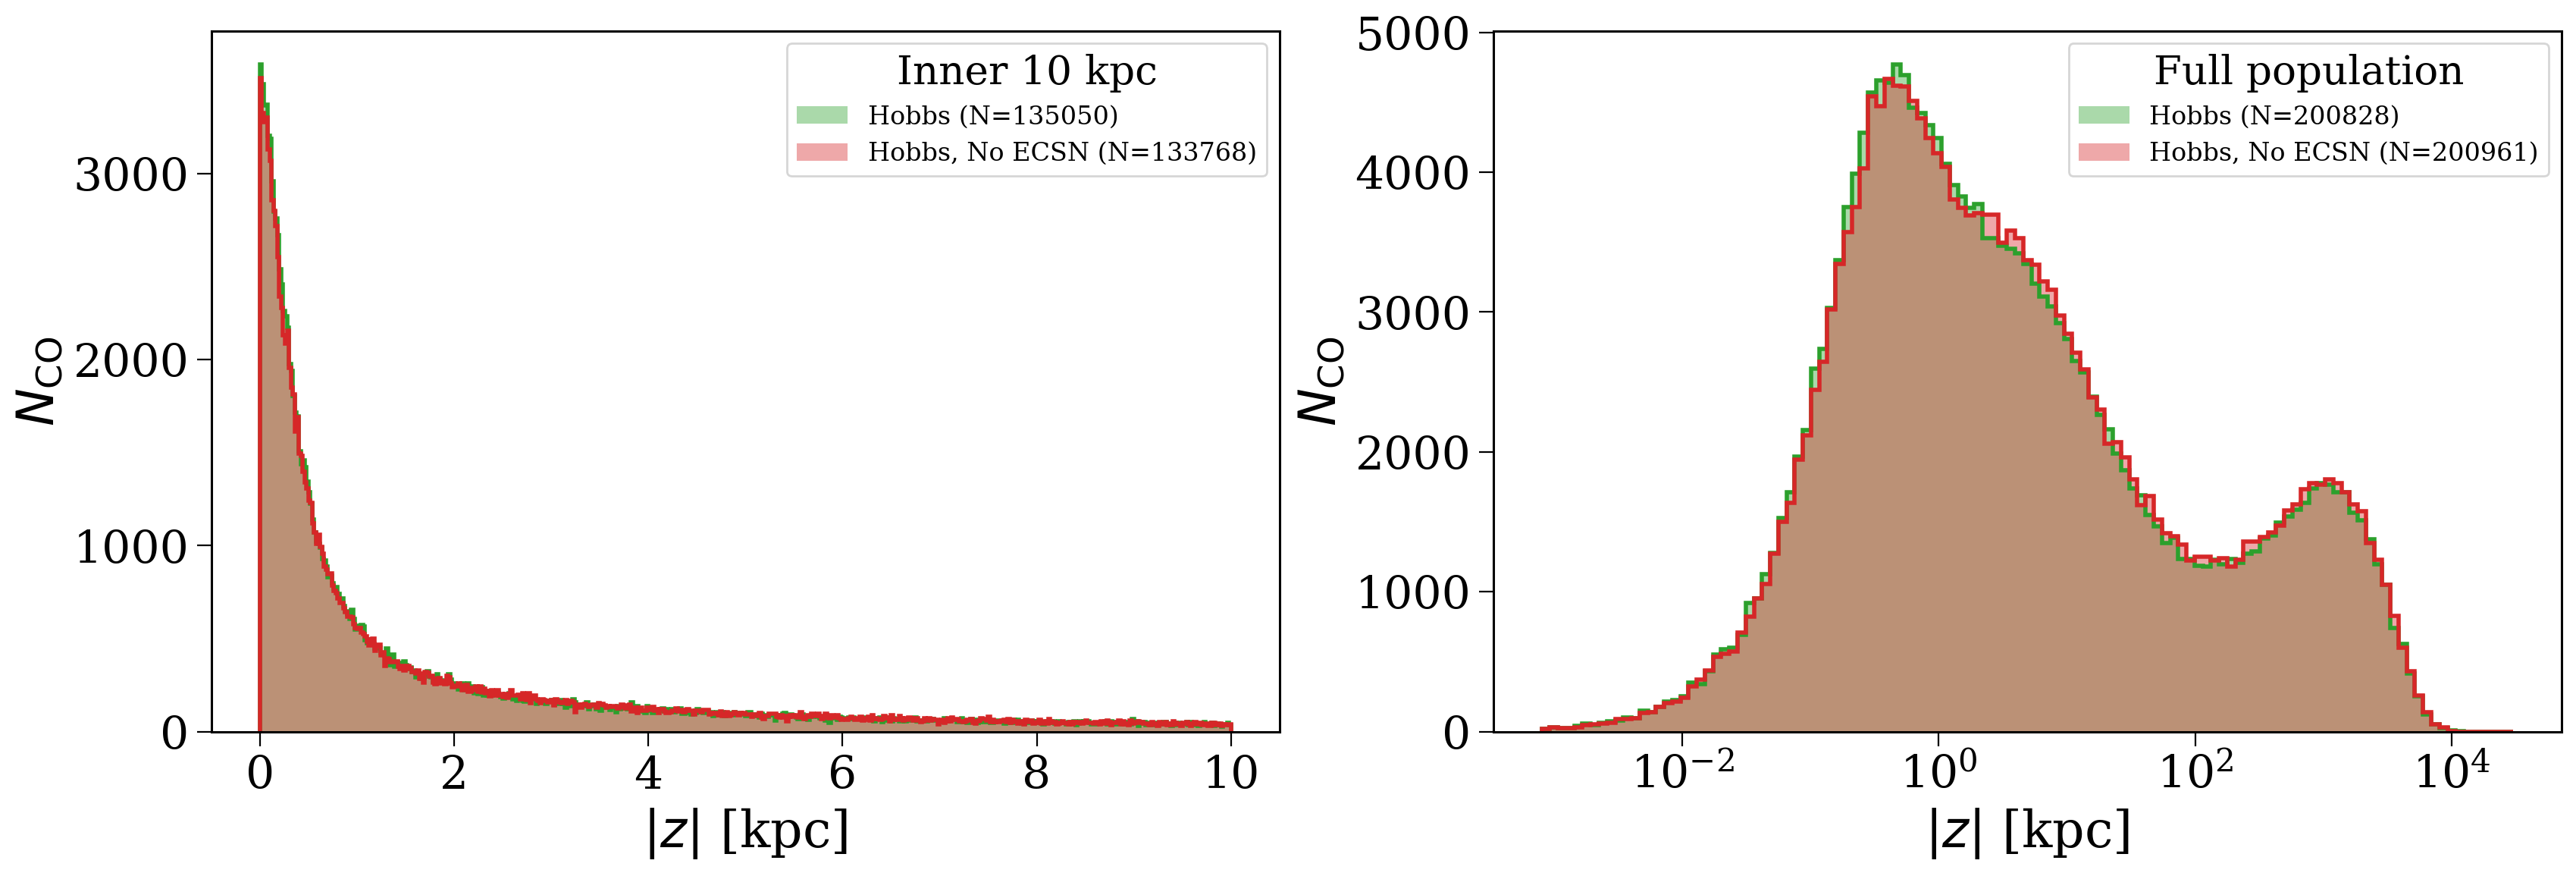

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

scales = ['linear', 'log']
bin_list = [np.linspace(0, 10, 501), np.geomspace(8e-4, 3e4, 120)]
labels = ['Inner 10 kpc', 'Full population']

for ax, scale, bins, label in zip(axes, scales, bin_list, labels):
    print(label)
    for pop in pops:
        if "Disberg" in pop.label:
            continue
        co_pos = kinematics[pop.label]["pos"]["CO"]

        mask = np.abs(co_pos[:, 2].to(u.kpc).value) < bins[-1]
        print(f"  {pop.label} fraction within 0.5 kpc {(abs(co_pos[:, 2].to(u.kpc).value) < 0.5).sum() / mask.sum():1.2f}")

        ax.hist(np.abs(co_pos[:, 2].to(u.kpc).value), bins=bins, histtype='step', lw=2, color=pop.colour)
        ax.hist(np.abs(co_pos[:, 2].to(u.kpc).value), bins=bins, alpha=0.4, color=pop.colour,
                label=f'{pop.label} (N={len(co_pos[mask])})')

    ax.set(
        xscale=scale,
        xlabel=r'$|z|$ [kpc]',
        ylabel=r'$N_{\rm CO}$',
    )
    ax.legend(title=label, fontsize=fs*0.5)
plt.show()

In [7]:
# calculate the fraction that escape the galaxy in each pop
escape_fractions = {}
for pop in pops:
    co_pos = kinematics[pop.label]["pos"]["CO"]
    co_vel = kinematics[pop.label]["vel"]["CO"]

    r = np.linalg.norm(co_pos.to(u.kpc).value, axis=1) * u.kpc
    v = np.linalg.norm(co_vel.to(u.km / u.s).value, axis=1) * u.km / u.s

    esc_vel = np.sqrt(-2 * pop.galactic_potential(co_pos.T)).to(u.km / u.s)

    escaped = v > esc_vel
    escape_fractions[pop.label] = escaped.sum() / len(escaped)

print("Escape fractions:")
for label, frac in escape_fractions.items():
    print(f'  - {label}:{(20-len(label))*" "} = {frac:1.3f}')

Escape fractions:
  - Disberg:              = 0.112
  - Disberg, No ECSN:     = 0.114
  - Hobbs:                = 0.168
  - Hobbs, No ECSN:       = 0.172


200182
200314
200909
201042


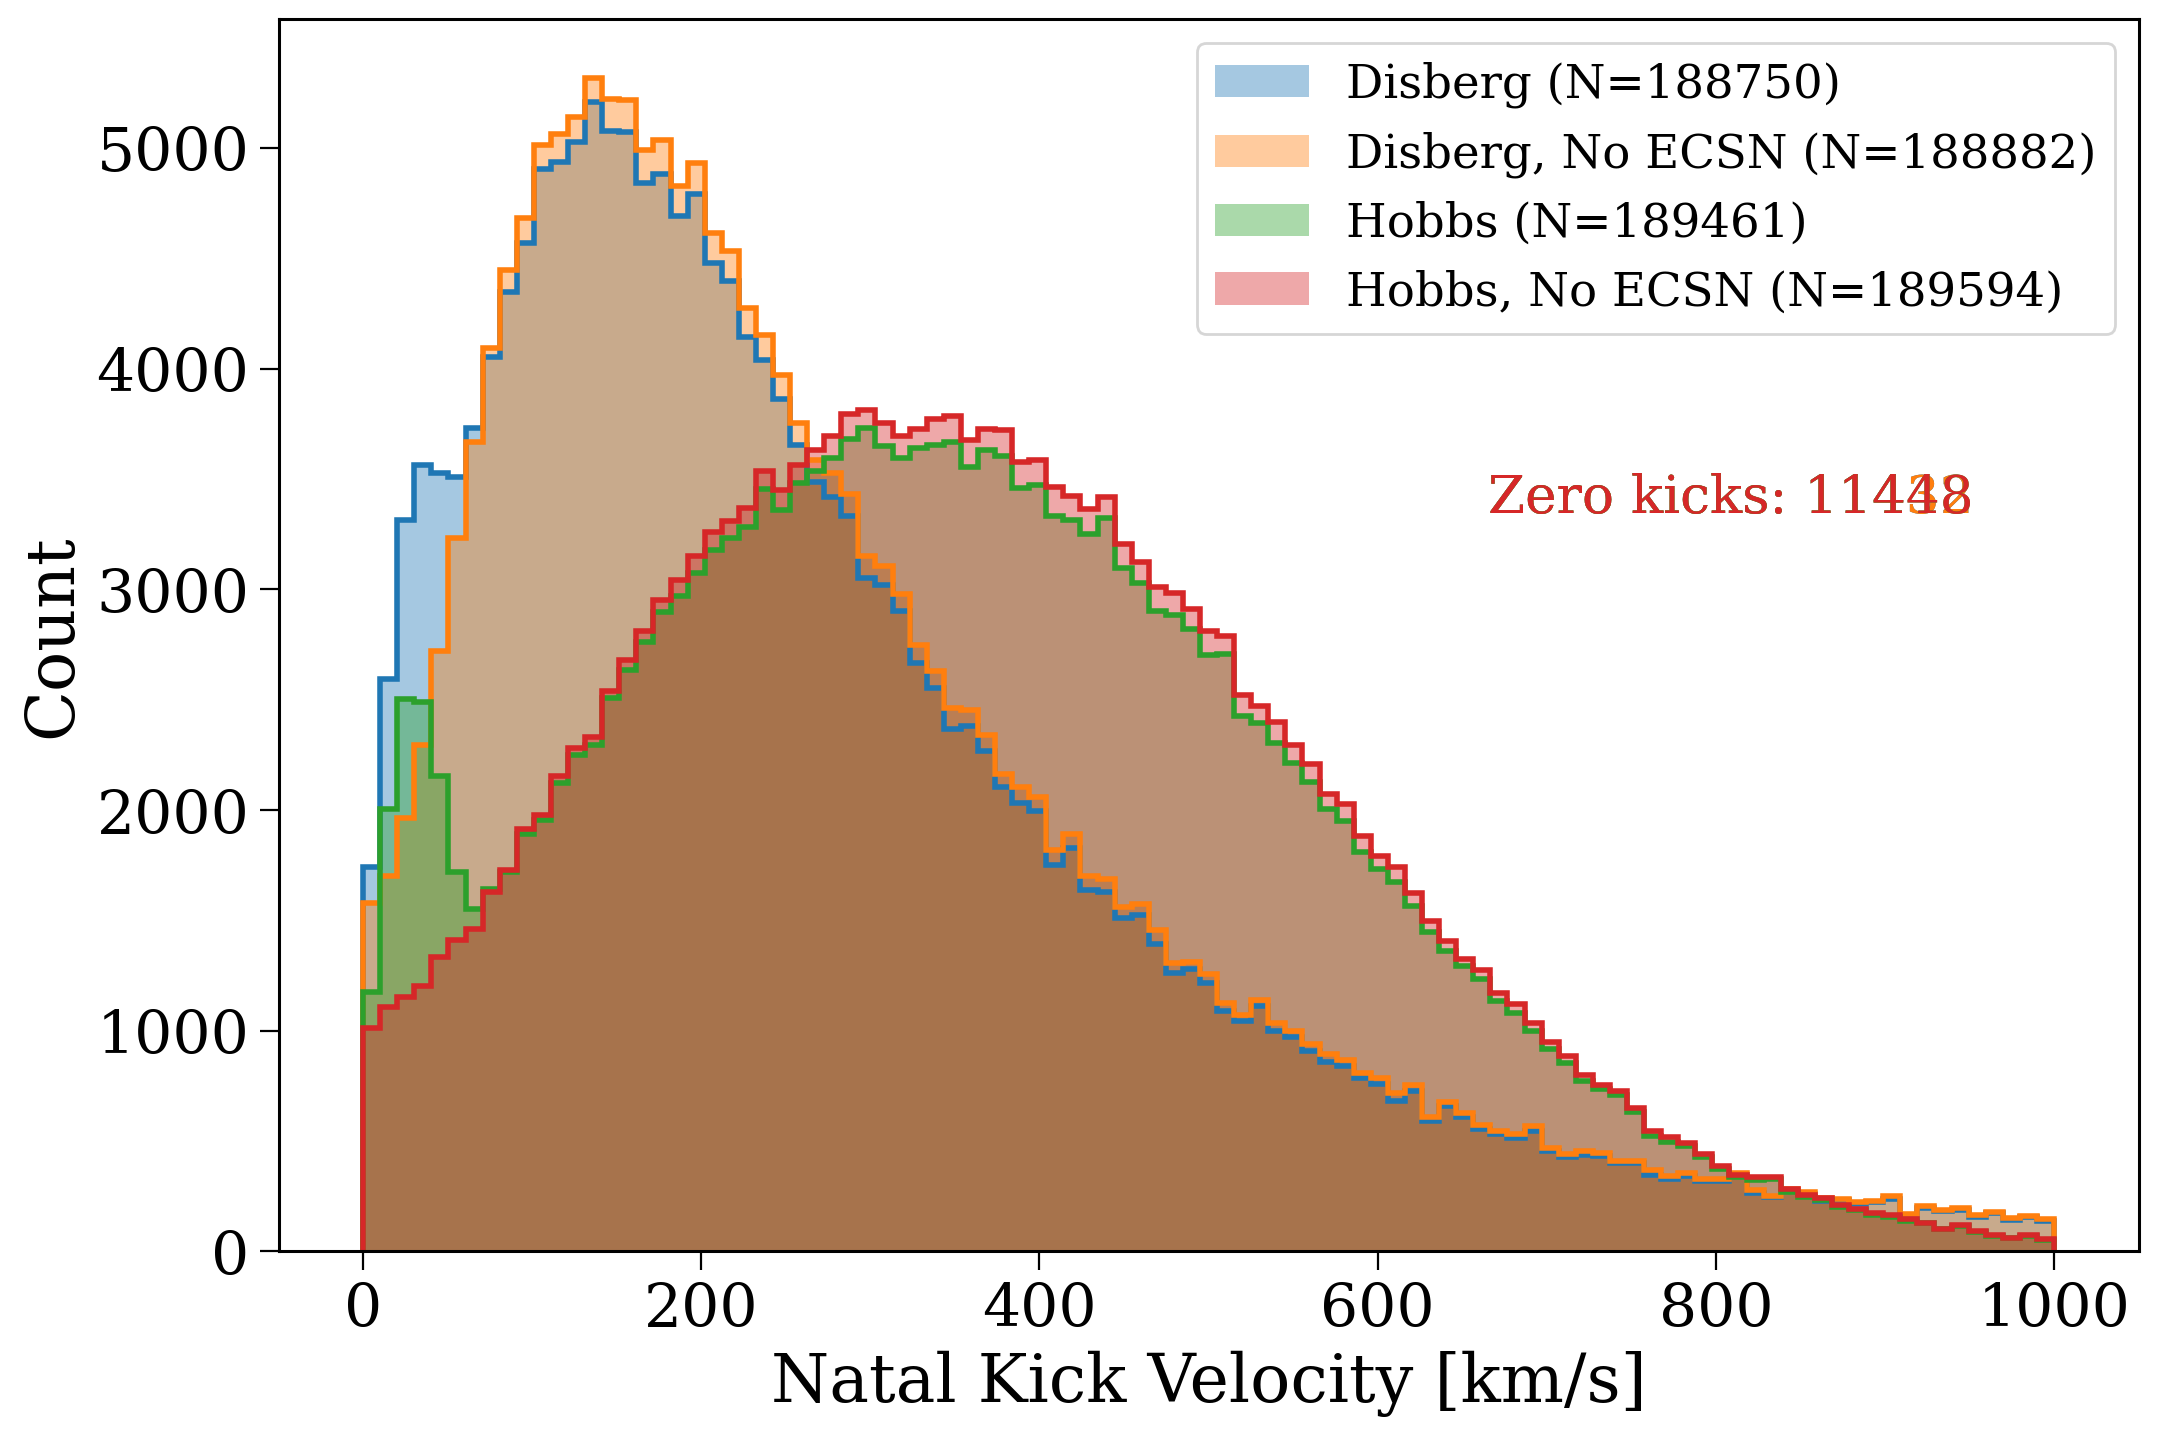

200182
200314
200909
201042


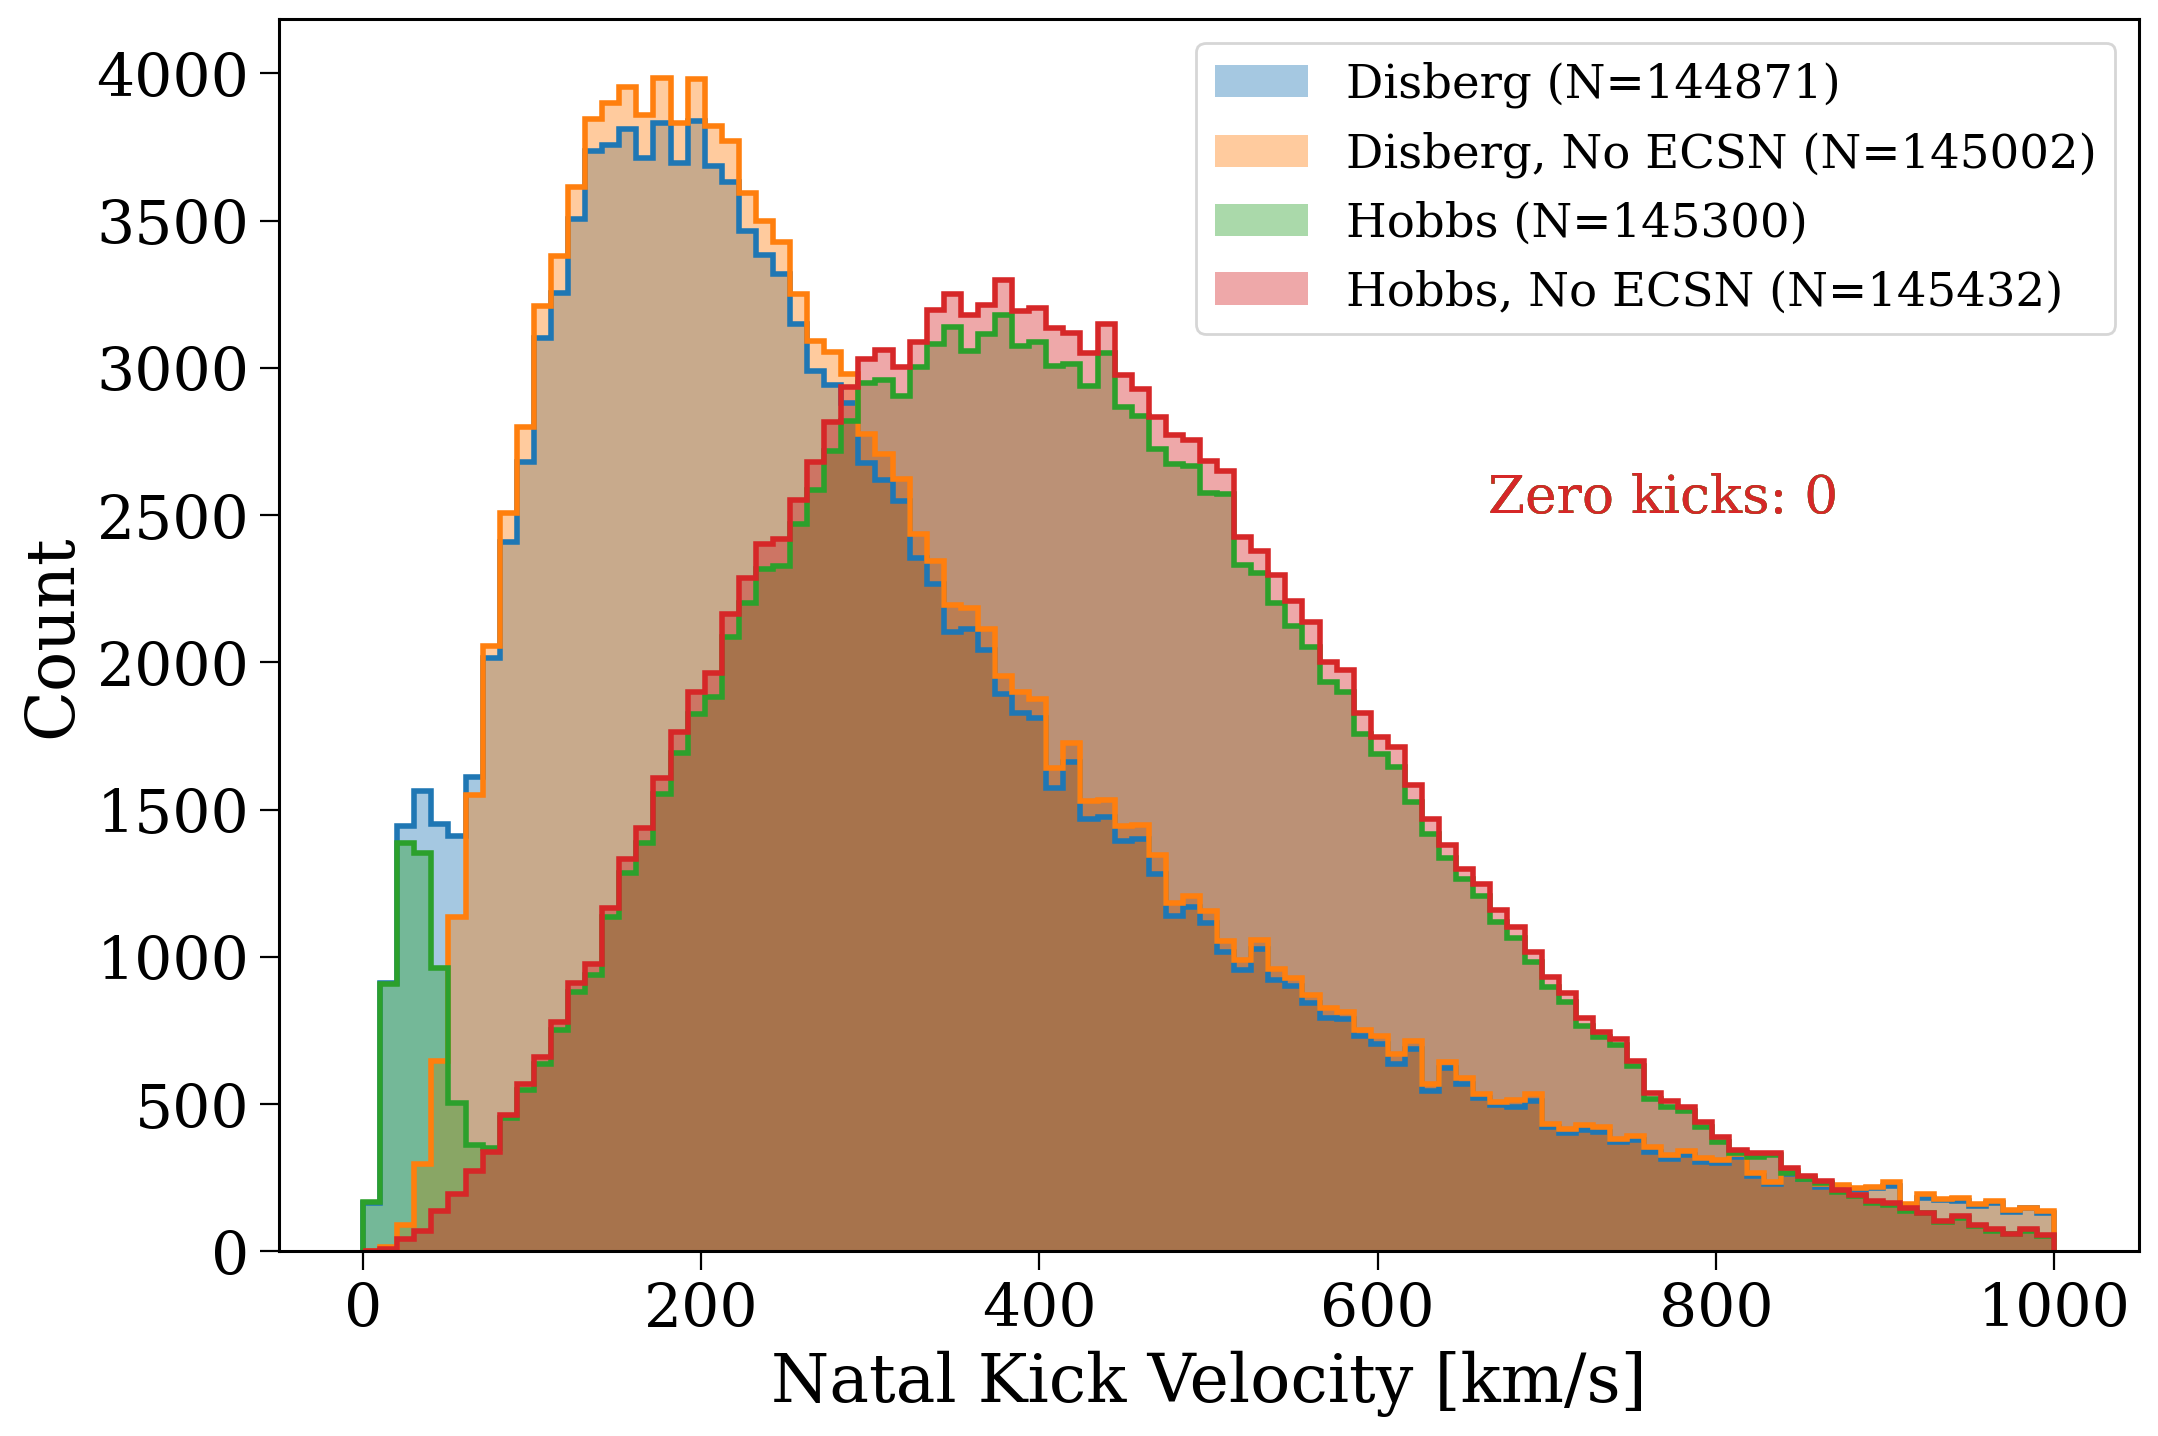

200182
200314
200909
201042


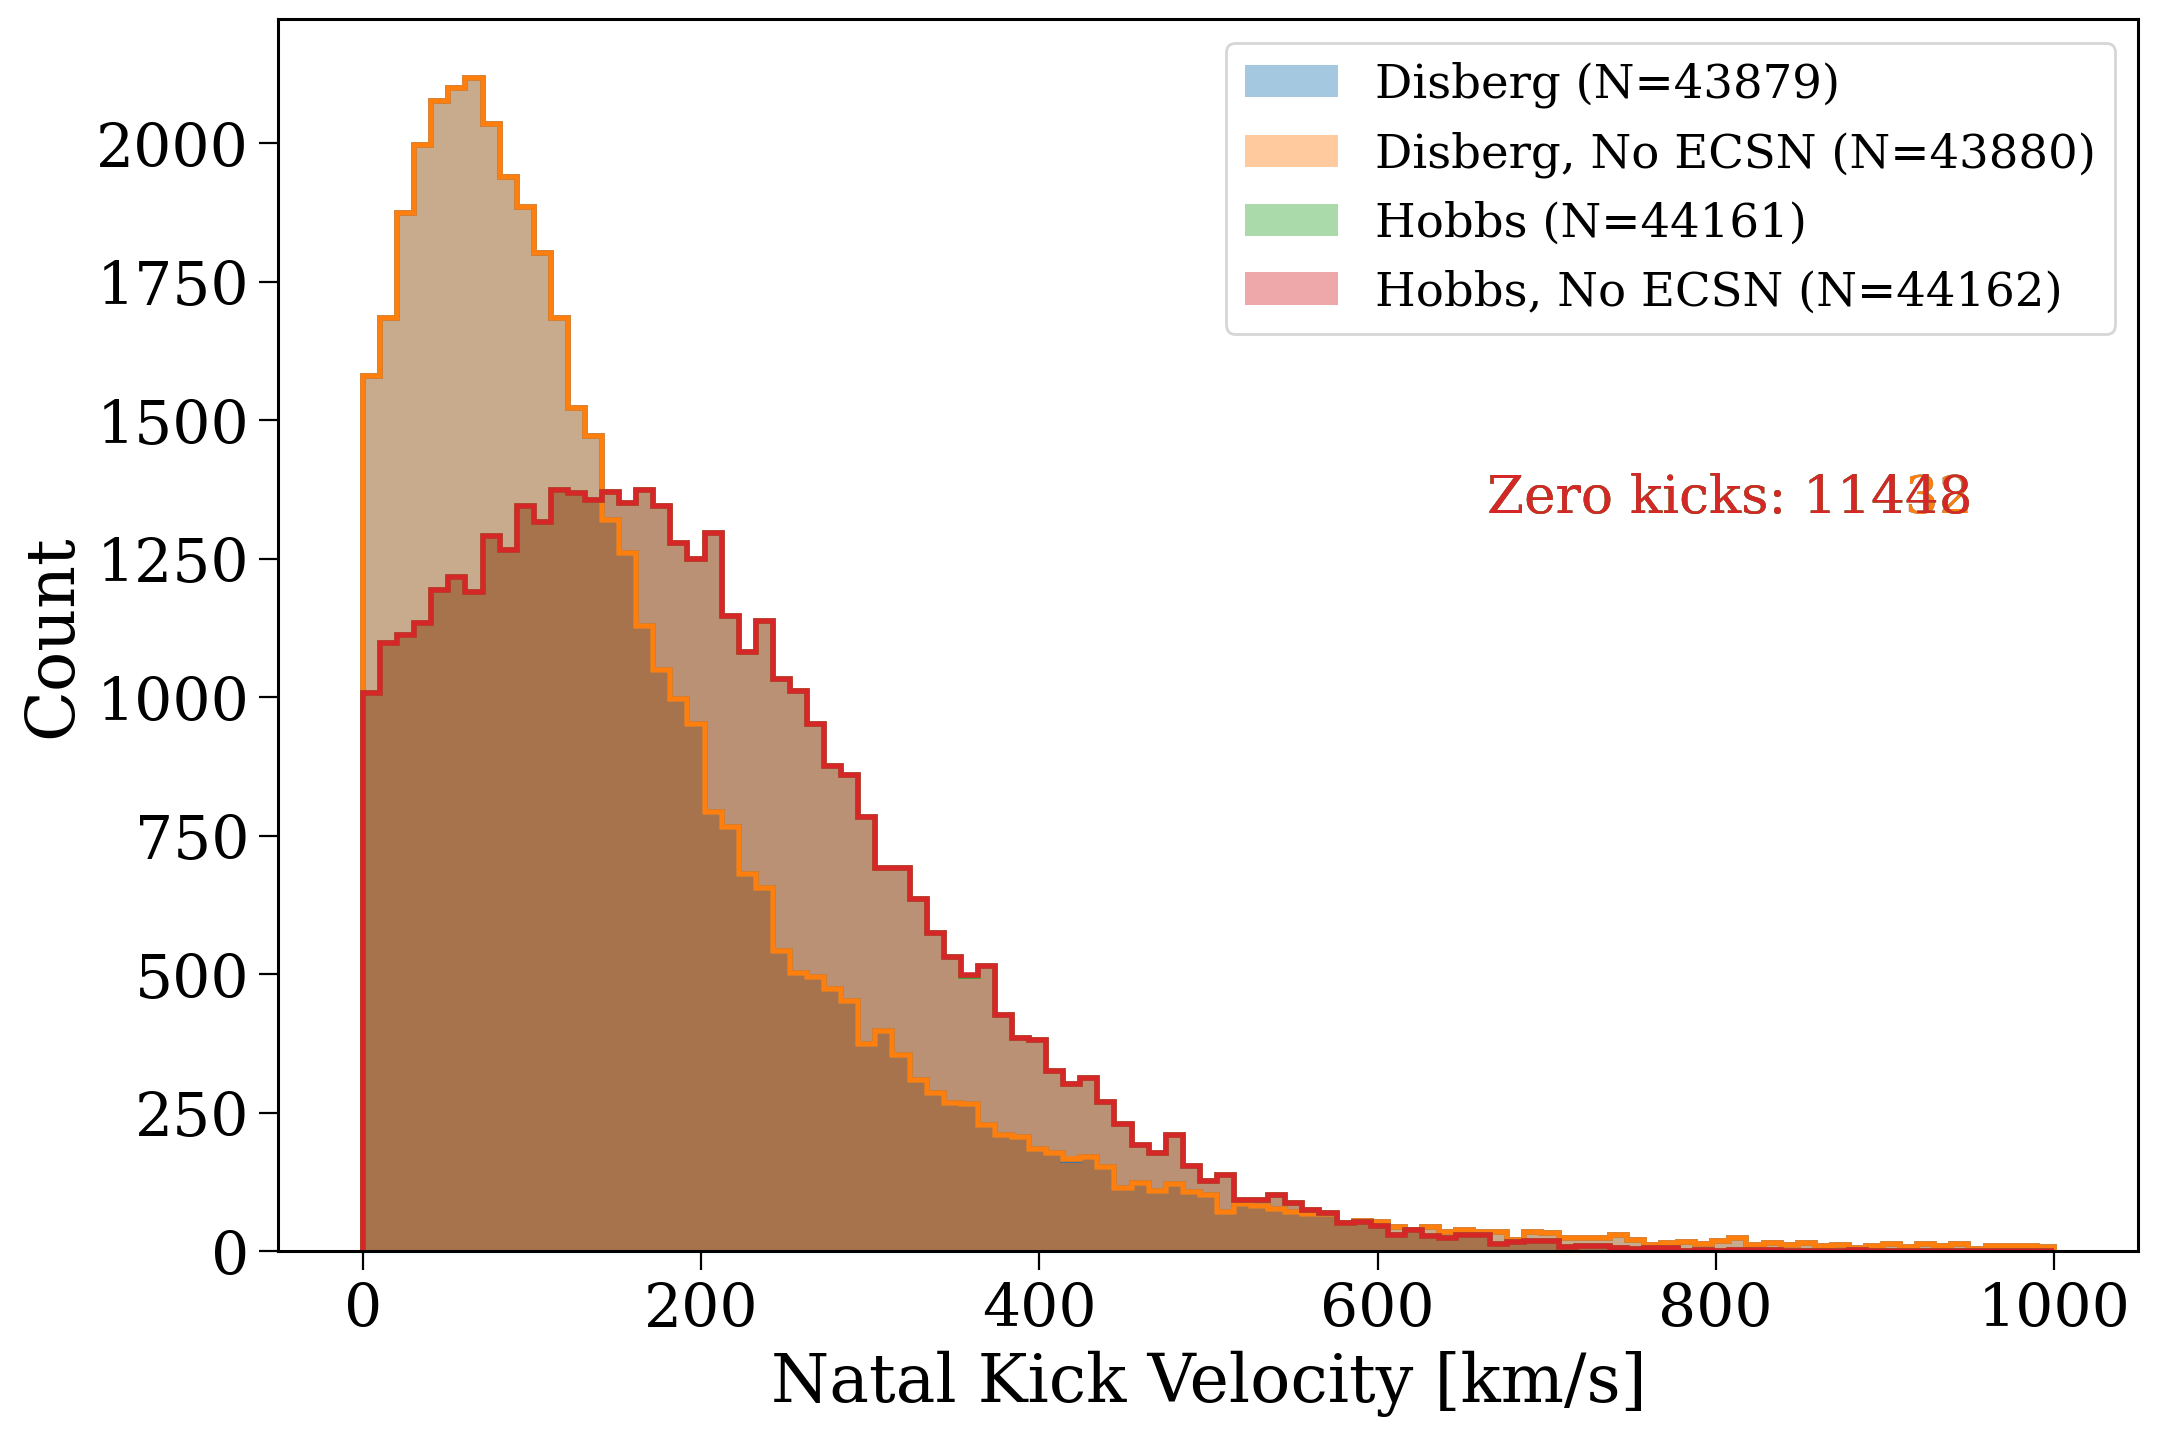

In [10]:
density = False
for co_type_label, co_type in zip(["ALL", "NS", "BH"], [[13, 14], [13], [14]]):

    fig, ax = plt.subplots()

    bins = np.linspace(0, 1000, 100)

    for pop in pops:
        kick_details = pop.kick_info[pop.kick_info["star"] != 0]
        kicks = kick_details["natal_kick"]
        print(len(kicks))

        kick_rows = pop.bpp[pop.bpp["evol_type"].isin([15, 16])]
        after_kick_rows = pop.bpp[pop.bpp["row_num"].isin(kick_rows["row_num"] + 1)]
        kick_co_type = np.where(kick_details["star"] == 1, after_kick_rows["kstar_1"], after_kick_rows["kstar_2"])
        
        kicks = kicks[(np.isin(kick_co_type, co_type))]
        n_zero_kicks = (kicks == 0.0).sum()
        kicks = kicks[(kicks != 0.0)]

        ax.hist(kicks, bins=bins, density=density, histtype='step', lw=2, color=pop.colour)
        ax.hist(kicks, bins=bins, density=density, alpha=0.4, color=pop.colour,
                label=f"{pop.label} (N={len(kicks)})")
        
        ax.annotate(
            f"Zero kicks: {n_zero_kicks}",
            xy=(0.65, 0.65 - 0.05 * (0 if pop.label == "Singles" else 1)),
            xycoords='axes fraction',
            color=pop.colour,
            fontsize=0.8*fs,
        )

    ax.set(
        xlabel="Natal Kick Velocity [km/s]",
        ylabel="Count",
    )
    ax.legend()
    plt.show()